In [49]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
basic_directory = Path.cwd()                            # directory of the file - folder "code"
data_directory = basic_directory.parent / "data"        # go one level up and choose folder "data"

# It's a common convention to add a _df suffix to a variable name to indicate it's a DataFrame.
flights_df  = pd.read_csv(data_directory / "flights.csv")
airlines_df = pd.read_csv(data_directory / "airlines.csv")
airports_df = pd.read_csv(data_directory / "airports.csv")
planes_df   = pd.read_csv(data_directory / "planes.csv")
weather_df  = pd.read_csv(data_directory / "weather.csv")

# Convert to datetime
flights_df['time_hour'] = pd.to_datetime(flights_df['time_hour'])
weather_df['time_hour'] = pd.to_datetime(weather_df['time_hour'])

# Remove timezone
weather_df['time_hour'] = weather_df['time_hour'].dt.tz_localize(None)

'''
Convert the 'time_hour' column in flights_df and weather_df to datetime64[ns] type, as it was 'object'.
This was necessary because a merge on date/time types was not possible otherwise.

The dtype for flights_df was datetime64[ns], while for weather_df it was datetime64[ns, UTC]. Removed the UTC timezone.
'''

"\nConvert the 'time_hour' column in flights_df and weather_df to datetime64[ns] type, as it was 'object'.\nThis was necessary because a merge on date/time types was not possible otherwise.\n\nThe dtype for flights_df was datetime64[ns], while for weather_df it was datetime64[ns, UTC]. Removed the UTC timezone.\n"

In [13]:
# WHERE clause
# Flights operated by Boeing 737

planes = planes_df.loc[planes_df['model'].str.startswith('737'), 'tailnum']
# planes_all = planes_df[['tailnum', 'model']]

flights = flights_df[flights_df['tailnum'].isin(planes)]

set_planes = set(planes_df.loc[planes_df['model'].str.startswith('737'), 'tailnum'])
set_all = set(flights_df['tailnum'].dropna())   # .dropna() removes NaN tailnum in flights_df, IF EXISTS
result = set_planes - (set_planes - set_all)

'''
flights = flights_df.loc[
    flights_df['tailnum'].isin(planes),
    ["year", "month", "day", "carrier", "flight", "tailnum", "origin", "dest"]
]
if it was necessary to choose specific columns
'''
print(len(result))
print(len(flights), "flights by Boeing 737")

595
1519 flights by Boeing 737


**Initial Dataset Overview**
* Total aircraft in registry: 3,322 planes

* Boeing 737 models in registry: 1,037 planes (31.2%)

* Total flights recorded: ~10,000 flights

* Flights operated by 737s: 1,518 flights (15.2%)

**Key Finding:**
Boeing 737 aircraft account for 31.2% of the total number of registered aircraft, 
but operate only 15.2% of all flights, indicating a relatively low load factor compared to their share in the registry.

**Refined Analysis:**
When considering only aircraft that have actually flown (based on last query from 03_set_operations):
* Active aircraft total: 2,324 planes

* Active Boeing 737s: 595 planes (25.6%)

**Insight:**
The utilization gap becomes more understandable - 25.6% of the active fleet (Boeing 737s) conducts 15.2% of flights.
While still showing lower-than-expected utilization, this refined perspective reveals that many 737s in the registry are likely not in active service, making the operational percentage more reasonable.


In [14]:
# Same as the first query, but adding the 'model' column from planes_df to flights_df

planes_737 = planes_df.loc[planes_df['model'].str.startswith('737'), ['tailnum', 'model']]

merged = flights_df.merge(planes_737, on='tailnum') # This creates a table with ALL columns from both planes_737 and flights_df.

result = merged[["year", "month", "day", "carrier", "flight", "tailnum", "origin", "dest", "model"]] # Just selecting the columns I need
print(result)

      year  month  day carrier  flight tailnum origin dest      model
0     2013      6   27      UA    1037  N34222    EWR  BOS    737-824
1     2013      7   31      UA    1244  N39418    EWR  SJU  737-924ER
2     2013      4   16      UA    1219  N28457    EWR  SEA  737-924ER
3     2013      1   24      DL     315  N3764D    JFK  SJU    737-832
4     2013      7   26      UA    1695  N13716    EWR  IAH    737-724
...    ...    ...  ...     ...     ...     ...    ...  ...        ...
1514  2013      1   29      UA    1139  N16709    EWR  DFW    737-724
1515  2013      8   13      WN    3928  N797MX    EWR  HOU    737-7H4
1516  2013      4   14      UA    1549  N13750    LGA  IAH    737-724
1517  2013      6    6      WN    3841  N916WN    EWR  MDW    737-7H4
1518  2013     12   21      DL    2357  N3749D    JFK  SAN    737-832

[1519 rows x 9 columns]


In [17]:
# Flights to airports on the East Coast

airports = airports_df.loc[airports_df['lon']>-80, ['faa', 'name']]   # east of 80° west longitude
flights = flights_df.loc[flights_df['dest'].isin(airports['faa']),
                         ["year", "month", "day", "carrier", "flight", "tailnum", "origin", "dest"]
                         ]
#or simply: flights = flights_df[flights_df['dest'].isin(airports)]
# which would select all columns
print(flights)

print("All faa:", len(set(airports_df['faa'])))
print("All destinations:", len(set(flights_df['dest'])))
# set() is a set (множество) it removes all duplicates and leaves only unique values

      year  month  day carrier  flight tailnum origin dest
0     2013      6   27      UA    1037  N34222    EWR  BOS
5     2013      5   31      AA    1762  N3AWAA    JFK  BOS
7     2013      4    1      B6    1307  N348JB    JFK  IAD
9     2013      3   29      US    2126  N956UW    LGA  BOS
26    2013      7   31      US    2144  N956UW    LGA  BOS
...    ...    ...  ...     ...     ...     ...    ...  ...
9975  2013      5   14      AA     854  N3DXAA    JFK  BOS
9978  2013      8   28      B6     118  N355JB    JFK  BOS
9979  2013      2    8      B6      42  N192JB    JFK  SYR
9988  2013      1    8      9E    4220  N824AY    JFK  RDU
9999  2013     11   18      EV    4695  N11548    EWR  RDU

[1868 rows x 8 columns]
All faa: 1458
All destinations: 99


**Key Finding:**
1,868 flights (18.7% of total) served East Coast destinations, primarily to major hubs like BOS and RDU.

**Insight:**
The analysis filtered destinations east of 80°W longitude, showing significant traffic concentration along the Eastern seaboard from NYC airports.

In [18]:
# SELECT clause

# For each airport, show the number of flights departing FROM it
counts = (
    flights_df
    .groupby('origin')
    .size()
    .reset_index(name='number') # Number of flights per origin
)

result = (
    flights_df[['origin']]
    .drop_duplicates()              # equivalent to SELECT DISTINCT origin
    .merge(counts, on='origin')     # adding the number of flights from counts
)

print(result)

  origin  number
0    EWR    3645
1    LGA    3079
2    JFK    3276


**Key Finding:**
EWR leads with 3,645 departures, followed by JFK (3,276) and LGA (3,079).

**Insight:** All three NYC airports maintain relatively balanced operations, with EWR handling the highest volume despite JFK's international prominence.

In [20]:
# Instead of a subquery in SELECT

query = flights_df.groupby('origin').size().reset_index(name='total_flights')
print(query)
'''
SELECT origin, COUNT(*) AS total_flights
FROM flights
GROUP BY origin;
'''

  origin  total_flights
0    EWR           3645
1    JFK           3276
2    LGA           3079


'\nSELECT origin, COUNT(*) AS total_flights\nFROM flights\nGROUP BY origin;\n'

     tailnum  number
305   N713MQ      20
167   N723MQ      18
641   N335AA      18
353   N711MQ      18
736   N722MQ      18
263   N725MQ      18
370   N334JB      17
1215  N339AA      17
540   N183JB      17
10    N298JB      17
3.54


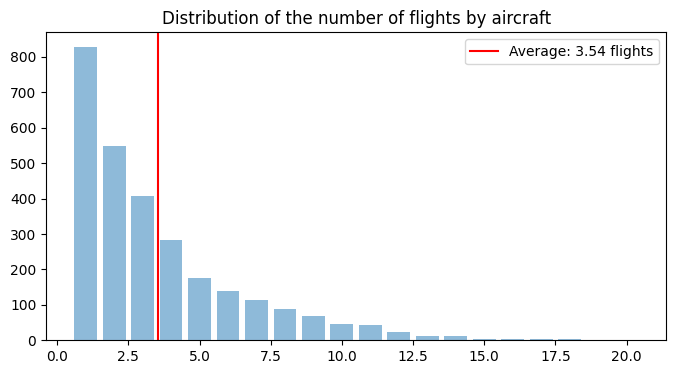

In [ ]:
# For each aircraft, show the total number of flights

notnull = flights_df[flights_df['tailnum'].notna()]
counts = (
    notnull
    .groupby('tailnum')
    .size()
    .reset_index(name="number")
)

result = (
    flights_df[['tailnum']]
    .drop_duplicates()
    .merge(counts, on='tailnum')
    .sort_values('number', ascending=False)
    .head(10)
)
print(result)

average_flights = round(counts['number'].mean(), 2)
print(average_flights)


# Creating a distribution of the number of flights by aircraft
flight_counts = (
    counts['number']
    .value_counts()
    .sort_index()
)   # Counts how many planes have each number of flights
# print(flight_counts)

plt.figure(figsize=(8, 4))
plt.bar(flight_counts.index, flight_counts.values, alpha=0.5)
plt.title('Distribution of the number of flights by aircraft')
plt.axvline(x=average_flights, color='red', label=f'Average: {average_flights} flights')
plt.legend()
plt.show()

**Key Finding:**
While top aircraft show heavy usage (17-20 flights each), the fleet-wide average is only 3.54 flights per aircraft.

**Insight:**
This indicates a highly skewed unimodal distribution, with most aircraft flying very infrequently and a small portion of the fleet performing the bulk of operations. The low average reflects significant idle capacity across the registry, despite the efficient utilization of core aircraft.

In [69]:
# FROM clause
# Average flight distance for each aircraft (by 'tailnum')
route_stats = (
    flights_df
    .groupby(["tailnum", "carrier"])["distance"]
    .mean().round(2)
    .reset_index(name="avg_distance")
)

result = planes_df.merge(route_stats, on="tailnum")                         # Add manufacturer and model
result = result.merge(airlines_df[["carrier", "name"]], on="carrier")       # Add the airline name from airlines_df
result = (
    result[["tailnum", "manufacturer", "model", "name", "avg_distance"]]
    .sort_values("avg_distance", ascending=False)
)

print(result)


     tailnum    manufacturer            model                    name  \
831   N382HA          AIRBUS         A330-243  Hawaiian Airlines Inc.   
861   N391HA          AIRBUS         A330-243  Hawaiian Airlines Inc.   
864   N392HA          AIRBUS         A330-243  Hawaiian Airlines Inc.   
853   N388HA          AIRBUS         A330-243  Hawaiian Airlines Inc.   
855   N389HA          AIRBUS         A330-243  Hawaiian Airlines Inc.   
...      ...             ...              ...                     ...   
2275  N967UW         EMBRAER  ERJ 190-100 IGW         US Airways Inc.   
2241  N955UW         EMBRAER  ERJ 190-100 IGW         US Airways Inc.   
2024  N8928A  BOMBARDIER INC      CL-600-2B19       Endeavor Air Inc.   
2039  N8968E  BOMBARDIER INC      CL-600-2B19       Endeavor Air Inc.   
1876  N829AY  BOMBARDIER INC      CL-600-2B19       Endeavor Air Inc.   

      avg_distance  
831        4983.00  
861        4983.00  
864        4983.00  
853        4983.00  
855        4983.00

**Key Finding:**
Individual aircraft operated by Hawaiian Airlines (Airbus A330-243) record the longest average distances - 4,983 miles. 
Smaller regional jets and turboprops (e.g., Embraer ERJ 190-100 and Bombardier CL-600) show significantly lower averages - under 200 miles.

**Insight:**
This contrast shows how the aircraft model and the airline's route network together determine flight length. 
Wide-body Airbus A330 aircraft are designed for long-haul flights, while regional aircraft are designed for short domestic flights. 
The dataset clearly separates the use of the aircraft fleet for long-haul flights and aircraft for short flights, highlighting the specialization of the aircraft fleet within airlines.

In [61]:
# Average flight distance for each company (by 'carrier')

carrier_stats = (
    flights_df.groupby("carrier")["distance"]
    .mean().round(2)
    .reset_index(name="avg_distance")
)

carrier_stats = carrier_stats.merge(airlines_df, on="carrier")
carrier_stats = carrier_stats[["carrier", "name", "avg_distance"]].sort_values("avg_distance", ascending=False)
print(carrier_stats)


   carrier                         name  avg_distance
8       HA       Hawaiian Airlines Inc.       4983.00
13      VX               Virgin America       2507.23
2       AS         Alaska Airlines Inc.       2402.00
6       F9       Frontier Airlines Inc.       1620.00
11      UA        United Air Lines Inc.       1579.20
1       AA       American Airlines Inc.       1339.93
4       DL         Delta Air Lines Inc.       1280.97
3       B6              JetBlue Airways       1071.08
14      WN       Southwest Airlines Co.        977.41
7       FL  AirTran Airways Corporation        652.13
9       MQ                    Envoy Air        568.15
5       EV     ExpressJet Airlines Inc.        562.97
12      US              US Airways Inc.        559.74
0       9E            Endeavor Air Inc.        534.31
15      YV           Mesa Airlines Inc.        465.25
10      OO        SkyWest Airlines Inc.        419.00


**Key Finding:**
Hawaiian Airlines leads with an exceptionally high average route length of 4,983 miles, followed by Virgin America (2,507 mi) and Alaska Airlines (2,402 mi). The shortest average routes belong to regional carriers such as SkyWest (419 mi) and Mesa Airlines (465 mi).

**Insight:**
This distribution reflects the operational focus of each airline. Hawaiian Airlines operates primarily long-haul inter-island routes, while low-cost and regional carriers perform short domestic hops

In [ ]:
# Average flight delays by month and airline

delay_stats = (
    flights_df[flights_df['dep_delay'].notna()]
    .groupby(['carrier', 'month'])['dep_delay']
    .agg(
        mean_delay='mean',
        median_delay='median',
        flight_count='size'
    )
    .reset_index()
)

delay_stats[['mean_delay', 'median_delay']] = delay_stats[['mean_delay', 'median_delay']].round(2)

delay_stats = delay_stats[(delay_stats['mean_delay'] > 15) & (delay_stats['flight_count'] > 5)]
result = airlines_df.merge(delay_stats, on='carrier')
result = result[['name', 'carrier', 'month', 'mean_delay', 'median_delay', 'flight_count']].sort_values('mean_delay', ascending=False)

print(result.head(10))
print(result.shape)


                           name carrier  month  mean_delay  median_delay  \
1             Endeavor Air Inc.      9E      2       50.13           0.0   
40       Southwest Airlines Co.      WN      8       45.39          14.5   
25  AirTran Airways Corporation      FL      5       43.88           4.0   
28                    Envoy Air      MQ      6       38.67          -1.0   
38       Southwest Airlines Co.      WN      6       35.97           8.5   
27  AirTran Airways Corporation      FL     12       33.38          10.0   
5             Endeavor Air Inc.      9E      7       32.65           3.0   
0             Endeavor Air Inc.      9E      1       31.70          -1.0   
23     ExpressJet Airlines Inc.      EV     12       31.48           4.0   
17     ExpressJet Airlines Inc.      EV      1       31.19           2.0   

    flight_count  
1             31  
40            28  
25             8  
28            64  
38            36  
27             8  
5             31  
0          

**Key Finding:**
Initially, the top of the ranking was dominated by airlines with only 1–2 recorded flights, leading to unrealistic averages.
After filtering for carriers with more than five flights, the highest mean delays were observed for Endeavor Air Inc. and Southwest Airlines Co., exceeding 50 and 45 minutes on average per month.
However, median delays for these and most other carriers remained close to zero, indicating that while a few flights experience severe delays, the majority of flights depart on time or even slightly early.

**Insight:**
This contrast between mean and median delay highlights the influence of outliers - rare but significant disruptions that inflate the average delay.
Most carriers maintain generally punctual operations, with only a small number of long delays skewing the mean upward.
Therefore, median delay provides a *more realistic measure* of typical passenger experience, while mean delay reflects sensitivity to *occasional extreme events*.

**Conclusion:**
Although certain airlines show high average delay times, their median performance suggests overall reliability.
Travelers can interpret this as: these carriers are usually on time, but when delays do occur, they tend to be long and infrequent.